### Problem Set 4
#### MACS 30100, Dr. Evans
#### Due Wednesday, Feb. 6 at 11:30am
#### Haowen Shang

#### 1. Some income data, lognormal distribution, and hypothesis testing.

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.optimize as opt
import pandas as pd
import warnings
%matplotlib notebook
warnings.filterwarnings("ignore")

In [2]:
# Load the data as a NumPy array
income = np.loadtxt('data/incomes.txt')

#### (a) Plot a histogram of percentages of the income.txt data with 30 bins.

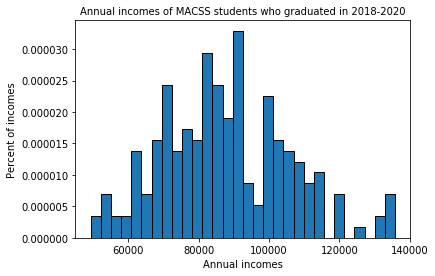

In [3]:
num_bins = 30
plt.hist(income, num_bins, normed=True, edgecolor='k')
plt.title('Annual incomes of MACSS students who graduated in 2018-2020', fontsize=10)
plt.xlabel('Annual incomes')
plt.ylabel('Percent of incomes')
plt.show()

#### (b) Plot the lognormal PDF. Calculate the log likelihood value for this parameterization of the distribution and given this data.

In [4]:
def lognorm(xvals, mu=11, sigma=0.5):
    return 1/(xvals*sigma * np.sqrt(2 * np.pi))*np.e**(-(np.log(xvals) - mu)**2 / (2 * sigma**2))

In [5]:
# Define function that generates values of a lognormal pdf
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu)) -
                              sts.lognorm.cdf(cut_lb, sigma,scale=np.exp(mu)))
            
    lognorm_pdf_vals = lognorm(xvals, mu, sigma)/prob_notcut
    
    return lognorm_pdf_vals

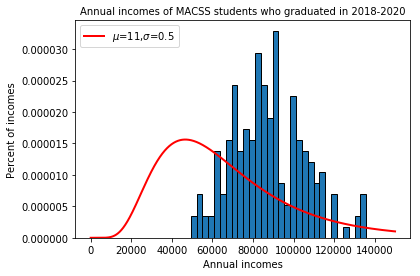

In [6]:
# Plot histogram
num_bins = 30
plt.hist(income, num_bins, normed=True, edgecolor='k')
plt.title('Annual incomes of MACSS students who graduated in 2018-2020', fontsize=10)
plt.xlabel('Annual incomes')
plt.ylabel('Percent of incomes')


#Plot smooth line with lognormal distribution
dist_income = np.linspace(0, 150000, 15000)
mu = 11
sigma = 0.5
cut_lb = 0
cut_ub = 150000
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu, sigma, cut_lb, cut_ub),
         linewidth=2, color='r', label='$\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

In [7]:
# Define log likelihood function for the lognormal distribution
def log_lik_truncnorm(xvals, mu, sigma, cut_lb, cut_ub):

    lognorm_pdf_vals = trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub)
    ln_lognorm_pdf_vals = np.log(lognorm_pdf_vals)
    log_lik_val = ln_lognorm_pdf_vals.sum()
    
    return log_lik_val

print('Log-likelihood value is: ', log_lik_truncnorm(income, 11, 0.5, 0, 'None'))

Log-likelihood value is:  -2385.856997808558


#### (c) Estimate the parameters of the lognormal distribution by maximum likelihood and plot its PDF.

In [8]:
def crit(params, *args):
   
    mu, sigma = params
    xvals, cut_lb, cut_ub = args
    log_lik_val = log_lik_truncnorm(xvals, mu, abs(sigma), cut_lb, cut_ub)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [9]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
mle_args = (income, 0, 'None')
results_uncstr = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE, sig_MLE = results_uncstr.x
loglik_val_MLE = log_lik_truncnorm(income, mu_MLE, sig_MLE, 0, 'None')

print('ML estimates for mu is', mu_MLE)
print('ML estimates for sigma is', sig_MLE)
print('The value of the likelihood function is: ', loglik_val_MLE)

ML estimates for mu is 11.359022989379836
ML estimates for sigma is 0.20817731563658817
The value of the likelihood function is:  -2241.7193013573587


In [10]:
vcv_MLE = results_uncstr.hess_inv
stderr_mu_mle = np.sqrt(vcv_MLE[0,0])
stderr_sig_mle = np.sqrt(vcv_MLE[1,1])


print('The variance-covariance matrix is: ', vcv_MLE)
print('Standard error for mu estimate is ', stderr_mu_mle)
print('Standard error for sigma estimate is ', stderr_sig_mle)

The variance-covariance matrix is:  [[2.21123790e-04 2.12729347e-06]
 [2.12729347e-06 1.09404079e-04]]
Standard error for mu estimate is  0.014870231658101566
Standard error for sigma estimate is  0.010459640472386483


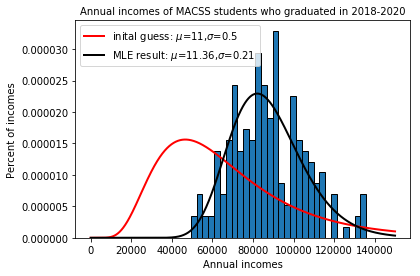

In [11]:
# Plot the histogram of the data
plt.hist(income, num_bins, normed=True, edgecolor='k')
plt.title('Annual incomes of MACSS students who graduated in 2018-2020', fontsize=10)
plt.xlabel('Annual incomes')
plt.ylabel('Percent of incomes')

# Plot the test distribution from before
plt.plot(dist_income,trunc_lognorm_pdf(dist_income, mu, sigma, cut_lb, cut_ub),
         linewidth=2, color='r', label='inital guess: $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

# Plot the MLE estimated distribution
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_MLE, sig_MLE, cut_lb, cut_ub),
         linewidth=2, color='k', label='MLE result: $\mu$=11.36,$\sigma$=0.21')
plt.legend(loc='upper left')

#### (d) Perform a likelihood ratio test to determine the probability that the data in incomes.txt came from the distribution in part (b).

In [12]:
mu_new, sig_new = np.array([11, 0.5])
log_lik_h0 = log_lik_truncnorm(income, mu_new, sig_new, 0, 'None')
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_truncnorm(income, mu_MLE, sig_MLE, 0, 'None')
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2385.856997808558
MLE log likelihood -2241.7193013573587
likelihood ratio value 288.2753929023984
chi squared of H0 with 2 degrees of freedom p-value =  0.0


From above results, we know that p-value is very small, so we can reject the null hypothesis that the data came from the distribution in part (b). Thus, the data is unlikely to have the distribution as in part (b).

#### (e) Using that estimated model from part (c), What is the probability that you will earn more than 100,000? What is the probability that you will earn less than 75,000?

In [13]:
p1 = 1-sts.lognorm.cdf(100000, sig_MLE, scale=np.exp(mu_MLE))
print("The probability that you will earn more than $100,000 is", p1)

p2 = sts.lognorm.cdf(75000, sig_MLE, scale=np.exp(mu_MLE))
print("The probability that you will earn less than $75,000 is", p2)

The probability that you will earn more than $100,000 is 0.2298668192367732
The probability that you will earn less than $75,000 is 0.2602342751189921


#### 2. Linear regression and MLE

#### (a) Estimate the parameters of the model (β0,β1,β2,β3,σ2) by maximum likelihood

In [14]:
# load the data
data_df = pd.read_csv('data/sick.txt').astype('float64')
# data_arr = np.array(data_df)
# data_df['cons'] = 1.0
data_df.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [15]:
#Define the functions
def norm_pdf(x, sigma):
    sigma = abs(sigma)
    pdf_vals = (1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - x**2 / (2 * sigma**2)))     
    return pdf_vals


def log_lik_norm(y, x1, x2, x3, beta0, beta1, beta2, beta3, sigma):
    err = y - beta0 - beta1*x1 - beta2*x2 - beta3*x3
    pdf_vals = norm_pdf(err, sigma)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    return log_lik_val


def newcrit(params,*args):
    
    beta0, beta1, beta2, beta3, sigma = params
    y, x1, x2, x3 = args
    log_lik_val = log_lik_norm(y, x1, x2, x3, beta0, beta1, beta2, beta3, sigma)
    neg_log_lik_val = -log_lik_val 
    
    return neg_log_lik_val


In [16]:
beta0_init, beta1_init, beta2_init, beta3_init = [0.2, 0.0, 0.0, 0.0]
sigma_init = 1
parameters_init = np.array([beta0_init, beta1_init, beta2_init, beta3_init, sigma_init])

y=data_df['sick']
x1, x2, x3 = data_df['age'], data_df['children'], data_df['avgtemp_winter']

results = opt.minimize(newcrit, parameters_init, (y, x1, x2, x3))
beta0_MLE, beta1_MLE, beta2_MLE, beta3_MLE, sigma_MLE = results.x
new_LLV_MLE = -results.fun
print('beta0_MLE =',beta0_MLE)
print('beta1_MLE =',beta1_MLE)
print('beta2_MLE =',beta2_MLE)
print('beta3_MLE =',beta3_MLE)
print('sigma_MLE =',sigma_MLE)
print("The value of the log likelihood function is",new_LLV_MLE)

beta0_MLE = 0.25164657743236246
beta1_MLE = 0.012933389662209218
beta2_MLE = 0.40050177159977757
beta3_MLE = -0.00999170144778414
sigma_MLE = 0.003017676295795841
The value of the log likelihood function is 876.8650477456889


In [17]:
new_vcv_MLE = results.hess_inv
print("The variance-covariance matrix is: ", new_vcv_MLE)

The variance-covariance matrix is:  [[ 1.02601558e-06  6.76217712e-09 -1.61457419e-07 -2.23447561e-08
  -2.62509024e-09]
 [ 6.76217712e-09  3.99882010e-09 -3.59520203e-08 -2.49007806e-09
  -2.98856777e-10]
 [-1.61457419e-07 -3.59520203e-08  3.75727605e-07  2.26789439e-08
   4.78055308e-10]
 [-2.23447561e-08 -2.49007806e-09  2.26789439e-08  1.95181525e-09
   2.90327774e-10]
 [-2.62509024e-09 -2.98856777e-10  4.78055308e-10  2.90327774e-10
   2.29769926e-08]]


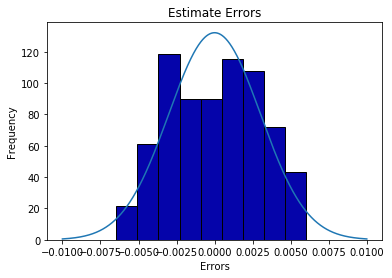

In [18]:
#Plot the histograms
err = y - beta0_MLE - beta1_MLE*x1 - beta2_MLE*x2 - beta3_MLE*x3
dist = np.linspace(-0.01, 0.01, 10000)

plt.hist(err, bins='auto', color='#0504aa', normed = True, edgecolor='k')
plt.xlabel('Errors')
plt.ylabel('Frequency')
plt.title('Estimate Errors')
plt.plot(dist, norm_pdf(dist, sigma_MLE))

#### (b) What is the likelihood that age, number of children, and average winter temperature have no effect on the number of sick days?

In [19]:
b0, b1, b2, b3, sig = 1, 0, 0, 0, 0.1
log_lik_h0 = log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sig)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = -results.fun
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -2253.700688042125
MLE log likelihood 876.8650477456889
likelihood ratio value 6261.131471575628
chi squared of H0 with 2 degrees of freedom p-value =  0.0


From above results, we know that p-value is very small, so we can reject the null hypothesis that that age, number of children, and average winter temperature have no effect on the number of sick days. Thus, it's unlikely that age, number of children, and average winter temperature have no effect on the number of sick days.